# Forecast-reforecast check
<!-- markdownlint-disable MD013 -->
Checking control forecast vs ensemble mean for forecast and reforecast

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from src.datasources import glofas
from src.utils import cds_utils
from src.constants import *

## Check reforecast ensemble mean vs control

In [3]:
df_ref_control = glofas.load_reforecast()

In [4]:
df_ref_ens = pd.read_parquet(
    glofas.GF_PROC_DIR / "wuroboki_glofas_reforecast_ens.parquet"
)

In [5]:
df_rea = glofas.load_glofas_reanalysis("wuroboki")

In [6]:
df_rea

,time,dis24
0,1979-01-01,79.656250
1,1979-01-02,77.609375
2,1979-01-03,76.515625
3,1979-01-04,75.671875
4,1979-01-05,74.843750
...,...,...
16736,2024-10-27,1411.625000
16737,2024-10-28,1280.859375
16738,2024-10-29,1156.441406
16739,2024-10-30,1043.812500


In [7]:
df_ref_ens

,number,time,dis24,valid_time,leadtime
9800,1,2003-07-03,446.265625,2003-07-04,1
10045,2,2003-07-03,439.984375,2003-07-04,1
10290,3,2003-07-03,451.453125,2003-07-04,1
10535,4,2003-07-03,447.546875,2003-07-04,1
10780,5,2003-07-03,449.187500,2003-07-04,1
...,...,...,...,...,...
8819,6,2022-10-30,94.867188,2022-12-04,35
9064,7,2022-10-30,91.257812,2022-12-04,35
9309,8,2022-10-30,91.617188,2022-12-04,35
9554,9,2022-10-30,91.328125,2022-12-04,35


In [8]:
df_ref_ens_mean = (
    df_ref_ens.groupby(["time", "valid_time", "leadtime"])["dis24"]
    .mean()
    .reset_index()
)

In [9]:
df_ref_ens_mean

,time,valid_time,leadtime,dis24
0,2003-07-03,2003-07-04,1,452.635925
1,2003-07-03,2003-07-05,2,573.265625
2,2003-07-03,2003-07-06,3,599.796875
3,2003-07-03,2003-07-07,4,563.751587
4,2003-07-03,2003-07-08,5,531.109375
...,...,...,...,...
26455,2022-10-30,2022-11-30,31,96.747658
26456,2022-10-30,2022-12-01,32,95.339066
26457,2022-10-30,2022-12-02,33,94.142189
26458,2022-10-30,2022-12-03,34,93.082809


In [10]:
df_ref_control

,time,dis24,valid_time,leadtime
0,2003-07-03,500.15625,2003-07-10,7
1,2003-07-03,577.60940,2003-07-05,2
2,2003-07-03,595.45310,2003-07-06,3
3,2003-07-03,552.92190,2003-07-07,4
4,2003-07-03,512.32810,2003-07-08,5
...,...,...,...,...
4895,2022-10-30,488.35156,2022-11-02,3
4896,2022-10-30,437.89844,2022-11-03,4
4897,2022-10-30,393.26562,2022-11-04,5
4898,2022-10-30,318.32030,2022-11-06,7


In [11]:
df_ref_compare = df_ref_control.merge(
    df_ref_ens_mean,
    on=["time", "valid_time", "leadtime"],
    suffixes=("_c", "_m"),
)

In [12]:
df_ref_compare["abs_diff"] = (
    df_ref_compare["dis24_m"] - df_ref_compare["dis24_c"]
)
df_ref_compare["frac_diff"] = (
    df_ref_compare["abs_diff"] / df_ref_compare["dis24_c"]
)
df_ref_compare["abs_frac_diff"] = df_ref_compare["frac_diff"].abs()

<Axes: >

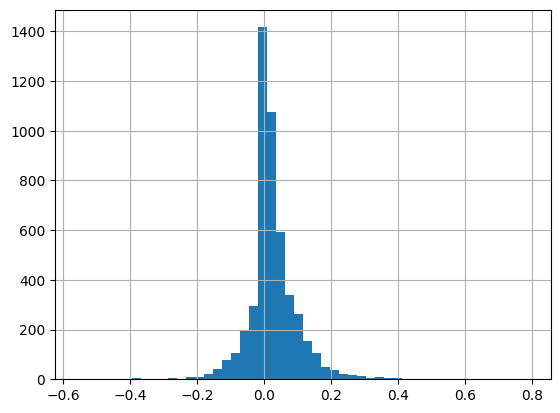

In [13]:
df_ref_compare["frac_diff"].hist(bins=50)

<Axes: xlabel='leadtime'>

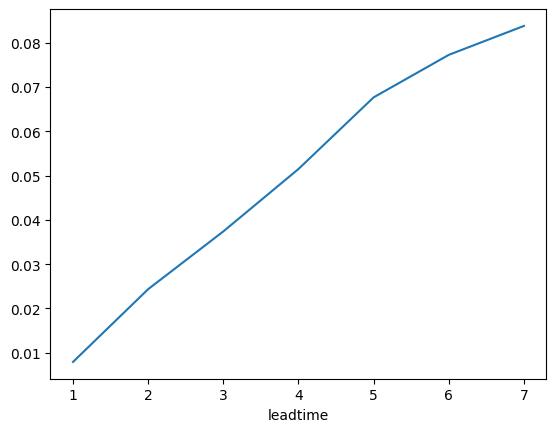

In [14]:
df_ref_compare.groupby("leadtime")["abs_frac_diff"].mean().plot()

In [15]:
df_ref_compare.corr()

,time,dis24_c,valid_time,leadtime,dis24_m,abs_diff,frac_diff,abs_frac_diff
time,1.000000e+00,0.033893,1.000000,1.519880e-15,0.041109,0.044470,0.038488,0.029831
dis24_c,3.389260e-02,1.000000,0.033920,2.849606e-02,0.984609,0.005691,-0.090152,0.066268
valid_time,9.999995e-01,0.033920,1.000000,9.494680e-04,0.041142,0.044502,0.038581,0.030219
leadtime,1.519880e-15,0.028496,0.000949,1.000000e+00,0.033947,0.033860,0.097429,0.409089
dis24_m,4.110939e-02,0.984609,0.041142,3.394692e-02,1.000000,0.180373,0.063982,0.122910
abs_diff,4.446953e-02,0.005691,0.044502,3.385959e-02,0.180373,1.000000,0.873450,0.330299
frac_diff,3.848815e-02,-0.090152,0.038581,9.742865e-02,0.063982,0.873450,1.000000,0.495684
abs_frac_diff,2.983062e-02,0.066268,0.030219,4.090888e-01,0.122910,0.330299,0.495684,1.000000


In [16]:
df_compare = df_ref_compare.merge(df_rea)
df_compare

,time,dis24_c,valid_time,leadtime,dis24_m,abs_diff,frac_diff,abs_frac_diff,dis24
0,2003-07-03,500.15625,2003-07-10,7,515.878113,15.721863,0.031434,0.031434,439.109375
1,2003-07-03,577.60940,2003-07-05,2,573.265625,-4.343775,-0.007520,0.007520,439.109375
2,2003-07-03,595.45310,2003-07-06,3,599.796875,4.343775,0.007295,0.007295,439.109375
3,2003-07-03,552.92190,2003-07-07,4,563.751587,10.829687,0.019586,0.019586,439.109375
4,2003-07-03,512.32810,2003-07-08,5,531.109375,18.781275,0.036659,0.036659,439.109375
...,...,...,...,...,...,...,...,...,...
4895,2022-10-30,488.35156,2022-11-02,3,488.301575,-0.049985,-0.000102,0.000102,607.562500
4896,2022-10-30,437.89844,2022-11-03,4,437.887512,-0.010928,-0.000025,0.000025,607.562500
4897,2022-10-30,393.26562,2022-11-04,5,394.100769,0.835149,0.002124,0.002124,607.562500
4898,2022-10-30,318.32030,2022-11-06,7,322.386719,4.066419,0.012775,0.012775,607.562500


In [17]:
df_corr = (
    df_compare.groupby("leadtime")[["dis24", "dis24_c", "dis24_m"]]
    .corr()
    .reset_index()
)
df_corr

,leadtime,level_1,dis24,dis24_c,dis24_m
0,1,dis24,1.000000,0.998434,0.996696
1,1,dis24_c,0.998434,1.000000,0.998447
2,1,dis24_m,0.996696,0.998447,1.000000
3,2,dis24,1.000000,0.981107,0.976423
4,2,dis24_c,0.981107,1.000000,0.995590
5,2,dis24_m,0.976423,0.995590,1.000000
6,3,dis24,1.000000,0.967848,0.964089
7,3,dis24_c,0.967848,1.000000,0.993512
8,3,dis24_m,0.964089,0.993512,1.000000
9,4,dis24,1.000000,0.950121,0.945698


<Axes: xlabel='leadtime'>

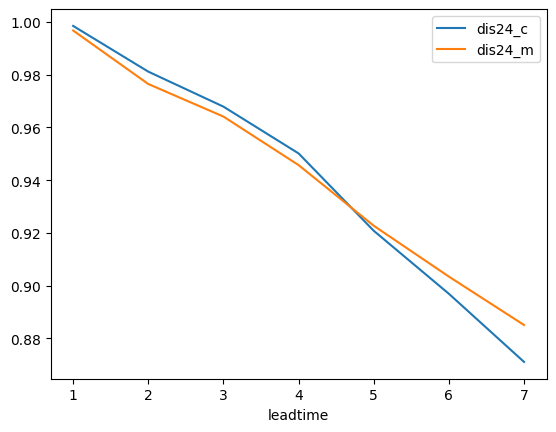

In [18]:
df_corr[df_corr["level_1"] == "dis24"].plot(
    x="leadtime", y=["dis24_c", "dis24_m"]
)

## Download forecast

In [89]:
forecast_dataset = "cems-glofas-forecast"
forecast_request = {
    "system_version": ["operational"],
    "hydrological_model": ["lisflood"],
    "product_type": ["control_forecast", "ensemble_perturbed_forecasts"],
    "variable": "river_discharge_in_the_last_24_hours",
    "year": ["2023"],
    "month": ["09"],
    "day": ["01", "02", "03", "04", "05", "06"],
    "leadtime_hour": ["24", "48", "72", "96", "120"],
    "data_format": "grib2",
    "download_format": "unarchived",
    "area": glofas.get_coords("wuroboki"),
}

In [19]:
blob_name = f"{PROJECT_PREFIX}/raw/glofas/forecast/forecast_2023_test.grib"

In [91]:
cds_utils.download_raw_cds_api_to_blob(
    dataset=forecast_dataset, request=forecast_request, blob_name=blob_name
)

2025-08-04 13:27:34,563 INFO [2024-09-26T00:00:00] Watch our [Forum]( https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum]( https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-08-04 13:27:35,102 INFO [2024-02-01T00:00:00] Please note that accessing this dataset via CDS for time-critical operation is not advised or supported
INFO:datapi.legacy_api_client:[2024-02-01T00:00:00] Please note that accessing this dataset via CDS for time-critical operation is not advised or supported
2025-08-04 13:27:35,105 INFO [2024-02-01T00:00:00] Please note we suggest checking the list of known issues on the GloFAS wiki
[here](https://confluence.ecmwf.int/display/CEMS/GloFAS+-+Known+Issues)
before downloading the dataset.
INFO:datapi.legacy_api_client:[2024-02-01T00:00:00] Please note we suggest checking the list of known issues on the GloFAS wiki
[here](https://confluence.ecmwf.i

16edffe651bec17f7549b94714e5bf41.grib:   0%|          | 0.00/369k [00:00<?, ?B/s]

PosixPath('temp/ds-aa-nga-flooding/raw/glofas/forecast/forecast_2022_test.grib')

In [20]:
filepath = "temp/" + blob_name
ds_cf = xr.load_dataset(filepath, filter_by_keys={"dataType": "cf"})
ds_pf = xr.load_dataset(filepath, filter_by_keys={"dataType": "pf"})

/Users/tdowning/.pyenv/versions/ds-aa-nga-flooding/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:125: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/tdowning/.pyenv/versions/ds-aa-nga-flooding/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:125: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


In [21]:
df_f_c_2023 = ds_cf.to_dataframe().reset_index()[
    ["time", "valid_time", "dis24"]
]

In [22]:
df_f_ens_2023 = ds_pf.to_dataframe().reset_index()[
    ["time", "valid_time", "number", "dis24"]
]

In [23]:
df_f_ens_mean_2023 = (
    df_f_ens_2023.groupby(["time", "valid_time"])["dis24"].mean().reset_index()
)

In [24]:
df_f_compare_2023 = df_f_ens_mean_2023.merge(
    df_f_c_2023,
    on=["time", "valid_time"],
    suffixes=("_c", "_m"),
)

## Download reforecast

Have to download reforecast again for 2023 since previous control forecast wasn't downloaded for this year

In [25]:
reforecast_dataset = "cems-glofas-reforecast"
reforecast_request = {
    "system_version": ["version_4_0"],
    "hydrological_model": ["lisflood"],
    "product_type": ["control_reforecast", "ensemble_perturbed_reforecast"],
    "variable": ["river_discharge_in_the_last_24_hours"],
    "hyear": ["2023"],
    "hmonth": ["09"],
    "hday": ["02", "05"],
    "leadtime_hour": ["24", "48", "72", "96", "120"],
    "data_format": "grib2",
    "download_format": "unarchived",
    "area": glofas.get_coords("wuroboki"),
}

In [26]:
blob_name = f"{PROJECT_PREFIX}/raw/glofas/reforecast/reforecast_2023_test.grib"

In [139]:
cds_utils.download_raw_cds_api_to_blob(
    dataset=reforecast_dataset, request=reforecast_request, blob_name=blob_name
)

2025-08-04 14:07:17,638 INFO [2024-09-26T00:00:00] Watch our [Forum]( https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum]( https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-08-04 14:07:18,393 INFO [2024-02-01T00:00:00] Please note we suggest checking the list of known issues on the GloFAS wiki
[here](https://confluence.ecmwf.int/display/CEMS/GloFAS+-+Known+Issues)
before downloading the dataset.
INFO:datapi.legacy_api_client:[2024-02-01T00:00:00] Please note we suggest checking the list of known issues on the GloFAS wiki
[here](https://confluence.ecmwf.int/display/CEMS/GloFAS+-+Known+Issues)
before downloading the dataset.
2025-08-04 14:07:18,395 INFO [2024-11-11T00:00:00] Temporary freeze of medium-range reforecasts available from the EWDS, with no update of the dataset from GloFAS v4.2 release date. If you require access to the reforecast data, please get i

bc7405fcacd3e3970a43ee9b4979cc13.grib:   0%|          | 0.00/26.5k [00:00<?, ?B/s]

PosixPath('temp/ds-aa-nga-flooding/raw/glofas/reforecast/reforecast_2023_test.grib')

In [27]:
filepath = "temp/" + blob_name
ds_ref_cf = xr.load_dataset(filepath, filter_by_keys={"dataType": "cf"})
ds_ref_pf = xr.load_dataset(filepath, filter_by_keys={"dataType": "pf"})

/Users/tdowning/.pyenv/versions/ds-aa-nga-flooding/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:125: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/tdowning/.pyenv/versions/ds-aa-nga-flooding/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:125: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


In [28]:
df_ref_c_2023 = ds_ref_cf.to_dataframe().reset_index()[
    ["time", "valid_time", "dis24"]
]

In [29]:
df_ref_ens_2023 = ds_ref_pf.to_dataframe().reset_index()[
    ["time", "valid_time", "number", "dis24"]
]

In [30]:
df_ref_ens_mean_2023 = (
    df_ref_ens_2023.groupby(["time", "valid_time"])["dis24"]
    .mean()
    .reset_index()
)

In [31]:
df_ref_ens_mean_2023

,time,valid_time,dis24
0,2023-09-02,2023-09-03,2098.001465
1,2023-09-02,2023-09-04,2134.696777
2,2023-09-02,2023-09-05,2132.562500
3,2023-09-02,2023-09-06,2190.158691
4,2023-09-02,2023-09-07,2298.704590
5,2023-09-05,2023-09-06,2342.285889
6,2023-09-05,2023-09-07,2264.867188
7,2023-09-05,2023-09-08,2155.548340
8,2023-09-05,2023-09-09,2135.067871
9,2023-09-05,2023-09-10,2209.582031


In [32]:
df_ref_compare_2023 = df_ref_c_2023.merge(
    df_ref_ens_mean_2023, on=["time", "valid_time"], suffixes=("_c", "_m")
)

In [33]:
df_ref_compare_2023

,time,valid_time,dis24_c,dis24_m
0,2023-09-02,2023-09-03,2099.421875,2098.001465
1,2023-09-02,2023-09-04,2187.726562,2134.696777
2,2023-09-02,2023-09-05,2324.031250,2132.562500
3,2023-09-02,2023-09-06,2345.773438,2190.158691
4,2023-09-02,2023-09-07,2383.382812,2298.704590
5,2023-09-05,2023-09-06,2342.171875,2342.285889
6,2023-09-05,2023-09-07,2267.429688,2264.867188
7,2023-09-05,2023-09-08,2135.234375,2155.548340
8,2023-09-05,2023-09-09,2032.867188,2135.067871
9,2023-09-05,2023-09-10,2021.937500,2209.582031


## Compare forecast and reforecast

In [34]:
df_compare_2023 = df_ref_compare_2023.merge(
    df_f_compare_2023, on=["time", "valid_time"], suffixes=("_ref", "_f")
)

In [35]:
df_compare_2023

,time,valid_time,dis24_c_ref,dis24_m_ref,dis24_c_f,dis24_m_f
0,2023-09-02,2023-09-03,2099.421875,2098.001465,2021.342285,2019.250000
1,2023-09-02,2023-09-04,2187.726562,2134.696777,2025.849487,2014.984375
2,2023-09-02,2023-09-05,2324.031250,2132.562500,2011.327637,2002.906250
3,2023-09-02,2023-09-06,2345.773438,2190.158691,2037.984375,2004.000000
4,2023-09-02,2023-09-07,2383.382812,2298.704590,2064.034668,1979.171875
5,2023-09-05,2023-09-06,2342.171875,2342.285889,2214.097900,2209.156250
6,2023-09-05,2023-09-07,2267.429688,2264.867188,2103.791992,2083.742188
7,2023-09-05,2023-09-08,2135.234375,2155.548340,1989.769043,1959.273438
8,2023-09-05,2023-09-09,2032.867188,2135.067871,1907.416992,1859.484375
9,2023-09-05,2023-09-10,2021.937500,2209.582031,1873.112671,1825.953125


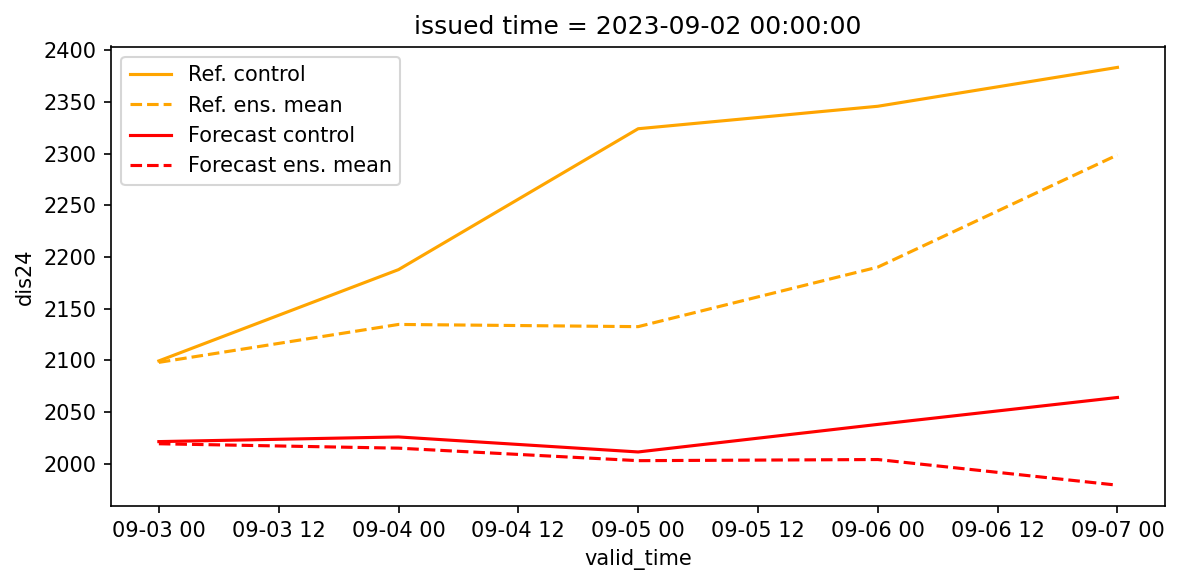

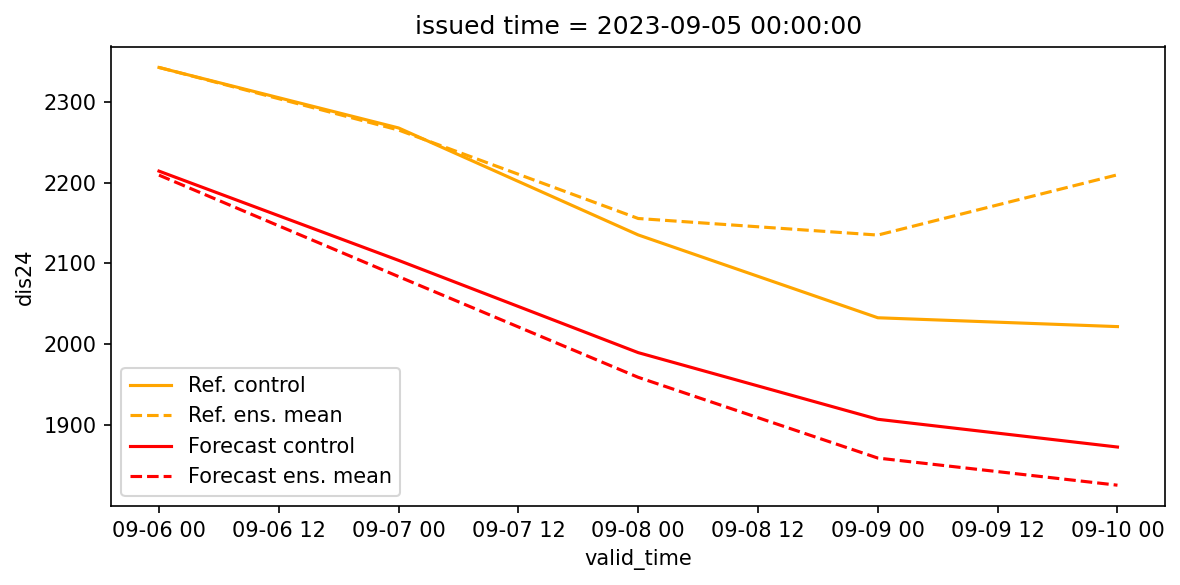

In [36]:
for t, group in df_compare_2023.groupby("time"):
    fig, ax = plt.subplots(figsize=(8, 4), dpi=150)

    ax.plot(
        group["valid_time"],
        group["dis24_c_ref"],
        color="orange",
        linestyle="-",
        label="Ref. control",
    )
    ax.plot(
        group["valid_time"],
        group["dis24_m_ref"],
        color="orange",
        linestyle="--",
        label="Ref. ens. mean",
    )
    ax.plot(
        group["valid_time"],
        group["dis24_c_f"],
        color="red",
        linestyle="-",
        label="Forecast control",
    )
    ax.plot(
        group["valid_time"],
        group["dis24_m_f"],
        color="red",
        linestyle="--",
        label="Forecast ens. mean",
    )

    ax.set_title(f"issued time = {t}")
    ax.set_xlabel("valid_time")
    ax.set_ylabel("dis24")
    ax.legend()

    plt.tight_layout()
    plt.show()